In [1]:
'''
This notebook implements a batch run for OFAT analysis
Packages
'''
from model import *
import csv
from mesa.batchrunner import BatchRunner
import pandas as pd
import numpy as np
import tqdm as tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import time
from SALib.sample import saltelli
from SALib.analyze import sobol
from itertools import combinations
from joblib import Parallel, delayed

In [2]:
'''
Defaults
'''
height = 20
width = 20
initial_houses = 100
initial_households = 150
savings_lower = 0
savings_upper = 0
price_lower = 100_000
price_upper = 1_000_000
payoff_perc_freehold = 0.0025
inflation = 0.02
house_price = 400_000
chi_parameter = 6.5
maximum_age = 100
minimum_age = 20
age_utility_scaling = 0.01
maximum_moving_age = 65
bank_income_multiplire = 8
fraction_good_houses = 0.05
price_shock_range = 6

In [2]:
columns = ('Variable', 'Parameter', 'Gini')

'''
This defines model run
'''
samples = 10
max_steps = 2
ofat_size = 5

In [3]:
def collect_samples(samples, columns, parameter, values):
    df_experiment = pd.DataFrame(columns=columns)
    parameter_name = parameter
    kwargs = {f'{parameter}':values}
    for k in range(int(samples)):
        '''
        Repeat trial with certain parameter k times to apply clt
        '''            
        model = HousingMarket(**kwargs)
        model.run_model(max_steps)
        data = model.datacollector.get_model_vars_dataframe()
        dic = {'Variable': parameter_name, 'Parameter': values, 'Gini': data['Gini'].iloc[-1]}
        df_experiment = pd.concat([df_experiment, pd.DataFrame(pd.Series(dic)).T])
    return df_experiment

def run_batch_parallel(problem, i, ofat_size, samples, columns):
    parameter = problem['names'][i]
    variable_values = np.linspace(*problem['bounds'][i], ofat_size)
    results = Parallel(n_jobs=8)(delayed(collect_samples)(samples, columns, parameter, value)
                       for value in variable_values)
    final = pd.concat(results)
    return final

def run_batch_parallel_plotter(result, i):
    '''
    This plots the result from running a batch runner in parallel
    '''
    
    fig = plt.plot( figsize = (20,40))
    y = []
    err = []
    x = np.linspace(*problem['bounds'][i], ofat_size)

    for j in range(len(x)):
        series = result['Gini'][int(j*samples):int((j+1)*samples)]
        y.append(series.mean())
        err.append(1.96 * (series.std()/np.sqrt(samples)))

    plt.plot(x, y , c='k')
    plt.fill_between(x, np.array(y) - np.array(err), np.array(y) + np.array(err)) 
    plt.ylabel("Gini")
    plt.xlabel(problem['names'][i])
    plt.show()

In [5]:
'''
This defines the bounds of for the ofat analysis
'''
problem = {
    'names': ['savings_lower', 'savings_upper', 'price_lower', 'price_upper', 
              'payoff_perc_freehold', 'inflation', 'chi_parameter', 'bank_income_multiplier'],
    'bounds': [[1, 40_000], [1, 100_000], [10_000, 90_000], [11_000, 100_000],
              [0.001,0.0025],[0.01,0.03],[5,7.5],[0,20]]    
}

columns = ('Variable', 'Parameter', 'Gini')

'''
This defines model run
'''
samples = 50
max_steps = 1000
# should be a multiple of your amount of cores
ofat_size = 12

In [ ]:
results = run_batch_parallel(problem, 7, ofat_size, samples, columns)
run_batch_parallel_plotter(results, 7)

In [8]:
results

,Variable,Parameter,Gini
0,bank_income_multiplier,bank_income_multiplier,0.330059
0,bank_income_multiplier,bank_income_multiplier,0.39093
0,bank_income_multiplier,bank_income_multiplier,0.431194
0,bank_income_multiplier,bank_income_multiplier,0.40192
0,bank_income_multiplier,bank_income_multiplier,0.334152
...,...,...,...
0,bank_income_multiplier,bank_income_multiplier,0.704185
0,bank_income_multiplier,bank_income_multiplier,0.722608
0,bank_income_multiplier,bank_income_multiplier,0.68568
0,bank_income_multiplier,bank_income_multiplier,0.694224


## Global Sensitivy Analysis

In [2]:
def run_SOBOL(values, problem, max_steps, counter):
    # build kwargs
    kwargs = {}
    for i, name in enumerate(problem['names']):
        kwargs[name] = values[i]
    model = HousingMarket(**kwargs)
    model.run_model(max_steps)
    data = model.datacollector.get_model_vars_dataframe()
        
    # add run data to the dictionary
    kwargs['Run'] = counter
    kwargs['Gini'] = data['Gini'].iloc[-1]

    return pd.DataFrame(pd.Series(kwargs)).T
    

In [3]:
'''
This section runs Sobol
'''
problem = {
    'num_vars': 8,
    'names': ['savings_lower', 'savings_upper', 'price_lower', 'price_upper', 
              'payoff_perc_freehold', 'inflation', 'chi_parameter', 'bank_income_multiplier'],
    'bounds': [[1, 40_000], [50_000, 100_000], [10_000, 90_000], [100_000, 1_000_000],
              [0.001,0.0025],[0.01,0.03],[5,7.5],[6,9]]    
}

In [13]:
replicates = 2
max_steps = 1000
distinct_samples = 8

In [14]:
'''
Generate Saltetlli sample
'''
param_values = saltelli.sample(problem, distinct_samples)
random.shuffle(param_values)

In [18]:
results = Parallel(n_jobs=8)(delayed(run_SOBOL)(param_values[i], problem, max_steps, 
                                                i)
                       for i in range(len(param_values)))

df_global = pd.concat(results)


In [7]:
sobal_gini = sobol.analyze(problem, df_global['Gini'].values, print_to_console = True )

                              ST   ST_conf
savings_lower           0.586677  0.974987
savings_upper           0.704450  0.903674
price_lower             0.674558  0.859667
price_upper             0.600465  1.050343
payoff_perc_freehold    0.574901  0.644636
inflation               0.899490  1.122602
chi_parameter           1.405212  0.807948
bank_income_multiplier  0.396039  0.314183
                              S1   S1_conf
savings_lower           0.018644  0.825776
savings_upper          -0.572987  0.859922
price_lower             0.020293  0.737667
price_upper             0.025638  0.601212
payoff_perc_freehold   -0.214667  0.829914
inflation               0.034643  1.056433
chi_parameter           0.346652  1.718566
bank_income_multiplier  0.069329  0.689487
                                                      S2   S2_conf
(savings_lower, savings_upper)                  0.469608  0.996171
(savings_lower, price_lower)                   -0.121867  0.971376
(savings_lower, price_upp

In [8]:
'''
Code from notebook
'''

def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

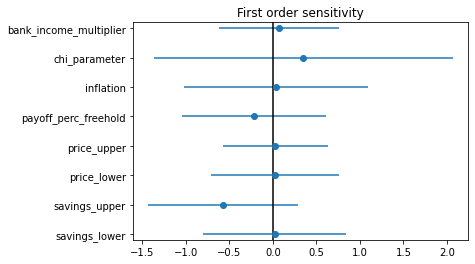

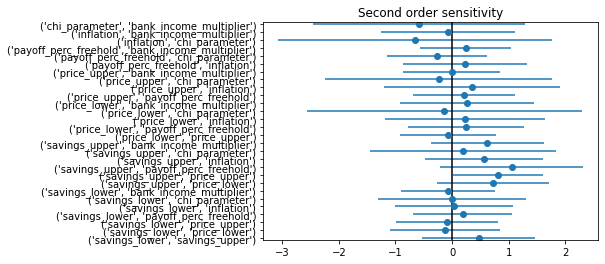

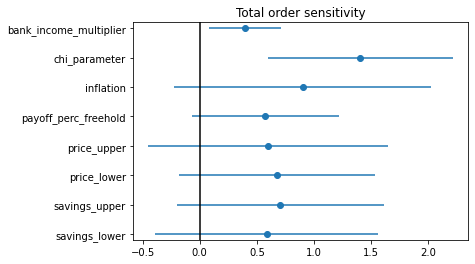

In [9]:
# First order
plot_index(sobal_gini, problem['names'], '1', 'First order sensitivity')
plt.show()

# Second order
plot_index(sobal_gini, problem['names'], '2', 'Second order sensitivity')
plt.show()

# Total order
plot_index(sobal_gini, problem['names'], 'T', 'Total order sensitivity')
plt.show()